In [1]:
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\Lucas\miniconda3\envs\gpu_nb\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

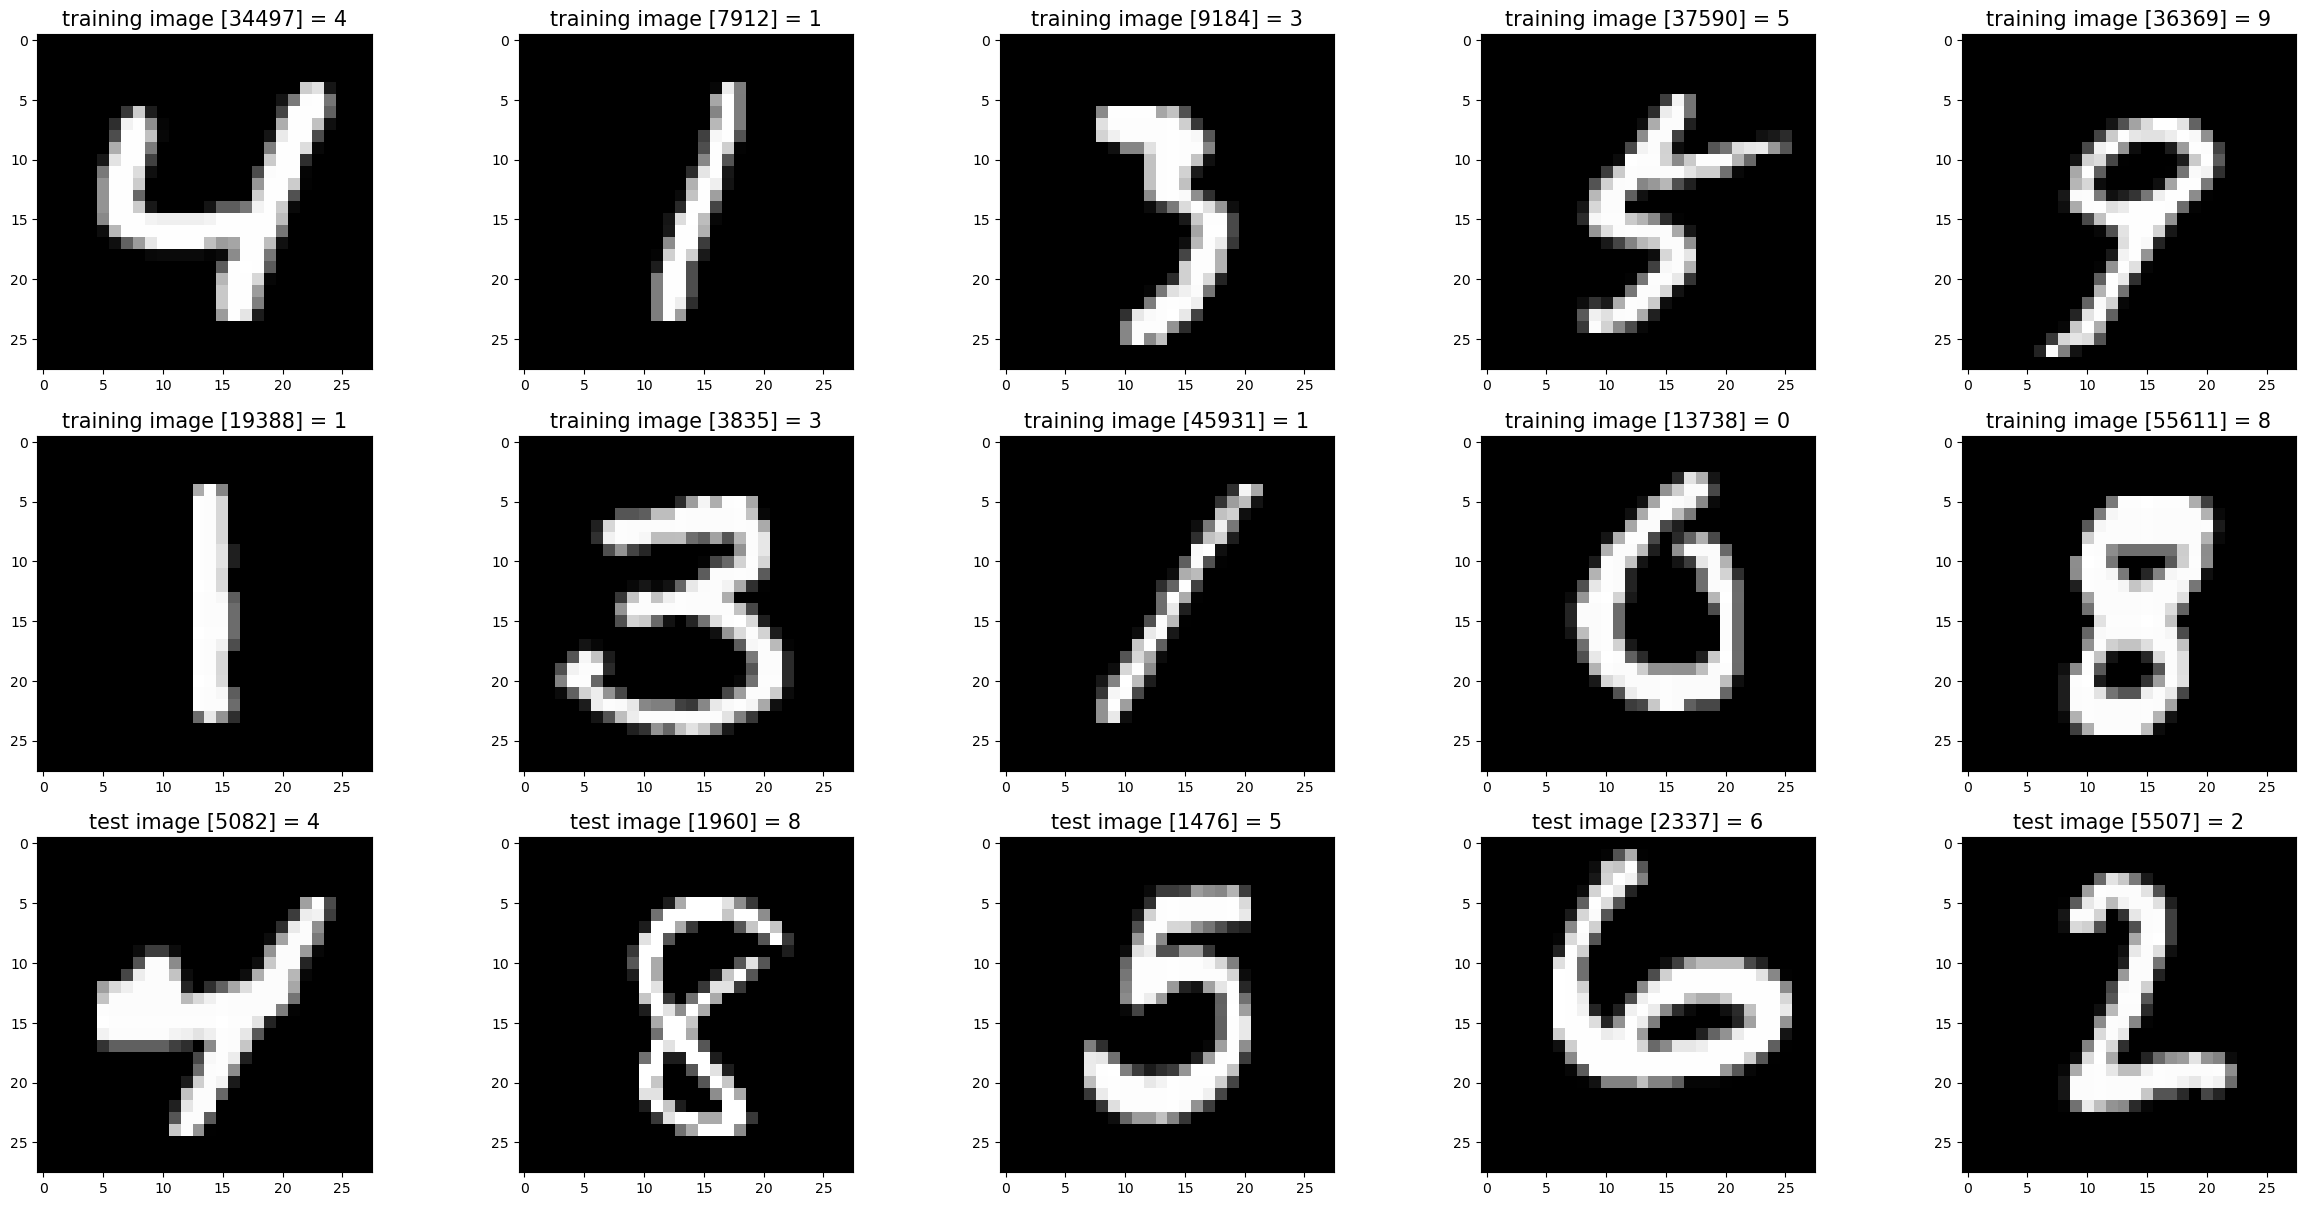

In [3]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'arquivos'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
    plt.show()
#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [4]:
x_train = cp.asarray(x_train)
y_train = cp.asarray(y_train)
x_test = cp.asarray(x_test)
y_test = cp.asarray(y_test)

x_train = x_train.reshape(x_train.shape[0], -1).T  
x_test = x_test.reshape(x_test.shape[0], -1).T
y_train = y_train.flatten()
y_test = y_test.flatten()

n_total = x_train.shape[1]  
indices = cp.arange(n_total)
cp.random.shuffle(indices)

x_train = x_train[:, indices]
y_train = y_train[indices]
val_size = int(n_total * 0.2)

x_val = x_train[:, :val_size]         
y_val = y_train[:val_size]

x_train_final = x_train[:, val_size:]  
y_train_final = y_train[val_size:]


REDE NEURAL USANDO CROSS ENTROPY LOSS

In [21]:
def ReLU(x):
    return cp.maximum(0, x)

def softmax(Z):
    expZ = cp.exp(Z - cp.max(Z, axis=0, keepdims=True))
    return expZ / cp.sum(expZ, axis=0, keepdims=True)

def deriv_ReLU(x):
    return x > 0

def one_hot(Y, num_classes=10):
    Y = cp.asarray(Y)
    one_hot_Y = cp.zeros((num_classes, Y.size))
    one_hot_Y[Y, cp.arange(Y.size)] = 1
    return one_hot_Y

def inicializar_parametros():
    W1 = cp.random.randn(64, 784) * 0.01
    b1 = cp.zeros((64, 1))
    W2 = cp.random.randn(10, 64) * 0.01
    b2 = cp.zeros((10, 1))
    return W1, b1, W2, b2

def forw_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def back_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = (1/m) * dZ2.dot(A1.T)
    db2 = (1/m) * cp.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = (1/m) * dZ1.dot(X.T)
    db1 = (1/m) * cp.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def atualizar_param(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 = W1 - dW1 * lr
    W2 = W2 - dW2 * lr
    b1 = b1 - db1 * lr
    b2 = b2 - db2 * lr
    return W1, b1, W2, b2

def compute_loss(A2, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    log_probs = cp.log(A2 + 1e-8)  # Adiciona epsilon para evitar log(0)
    loss = -cp.sum(one_hot_Y * log_probs) / m
    return loss

In [30]:
def prediction(x):
    return cp.argmax(x, axis=0)

def acc(pred, y):
    #print(pred, y)
    return cp.sum(pred == y) / y.size

def gradient_descent(X, Y,x_val, y_val, iterations, lr):
    W1, b1, W2, b2 = inicializar_parametros()
    train_accuracies = []
    val_accuracies = []
    steps = []
    train_losses = []
    val_losses = []

    for i in range(iterations):
        Z1, A1, Z2, A2 = forw_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = atualizar_param(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        if i % 10 == 0:
            _, _, _, A2_train = forw_prop(W1, b1, W2, b2, X)
            train_preds = prediction(A2_train)
            train_acc = acc(train_preds, Y)
            train_loss = compute_loss(A2_train, Y)

            _, _, _, A2_val = forw_prop(W1, b1, W2, b2, x_val)
            val_preds = prediction(A2_val)
            val_acc = acc(val_preds, y_val)
            val_loss = compute_loss(A2_val, y_val)

            steps.append(i)
            train_accuracies.append(cp.asnumpy(train_acc))
            val_accuracies.append(cp.asnumpy(val_acc))
            train_losses.append(cp.asnumpy(train_loss))
            val_losses.append(cp.asnumpy(val_loss))
            

            print(f"Iter {i}: acc_treino={train_acc:.4f}, acc_val={val_acc:.4f}, "
                  f"loss_treino={train_loss:.4f}, loss_val={val_loss:.4f}")
    return W1, b1, W2, b2, steps, train_accuracies, val_accuracies, train_losses, val_losses

In [35]:
def stochastic_grad(X, Y,x_val, y_val, lr, batch, epochs):
    W1, b1, W2, b2 = inicializar_parametros()
    train_accuracies = []
    val_accuracies = []
    steps = []
    train_losses = []
    val_losses = []
    best_val_acc = -1
    best_params = None
    
    m = X.shape[1]

    for epoch in range(epochs):
        indices = cp.random.permutation(m)
        X_shuffled = X[:, indices]
        Y_shuffled = Y[indices]

        
        for i in range(0, m, batch):
            X_batch = X_shuffled[:, i:i+batch]
            Y_batch = Y_shuffled[i:i+batch]

            Z1, A1, Z2, A2 = forw_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X_batch, Y_batch)
            batch_len = Y_batch.size
            dW1 /= batch_len
            db1 /= batch_len
            dW2 /= batch_len
            db2 /= batch_len

            # Atualiza os parâmetros
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2
        
        if epoch % 10 == 0:
            _, _, _, A2_train = forw_prop(W1, b1, W2, b2, X)
            train_preds = prediction(A2_train)
            train_acc = acc(train_preds, Y)
            train_loss = compute_loss(A2_train, Y)

            _, _, _, A2_val = forw_prop(W1, b1, W2, b2, x_val)
            val_preds = prediction(A2_val)
            val_acc = acc(val_preds, y_val)
            val_loss = compute_loss(A2_val, y_val)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {
                    "W1": W1.copy(),
                    "b1": b1.copy(),
                    "W2": W2.copy(),
                    "b2": b2.copy(),
                    "epoch": epoch,
                    "val_acc": val_acc,
                }

            steps.append(epoch)
            train_accuracies.append(cp.asnumpy(train_acc))
            val_accuracies.append(cp.asnumpy(val_acc))
            train_losses.append(cp.asnumpy(train_loss))
            val_losses.append(cp.asnumpy(val_loss))

            print(f"Iter {epoch}: acc_treino={train_acc:.4f}, acc_val={val_acc:.4f}, "
                  f"loss_treino={train_loss:.4f}, loss_val={val_loss:.4f}")
    return best_params, steps, train_accuracies, val_accuracies, train_losses, val_losses

In [38]:
best_params, steps_stoch, train_accs_stoch, val_accs_stoch, train_losses_stoch, val_losses_stoch = stochastic_grad(
    x_train_final, y_train_final, x_val, y_val, lr=0.01, batch=32, epochs=150
)

W1_stoch = best_params["W1"]
b1_stoch = best_params["b1"]
W2_stoch = best_params["W2"]
b2_stoch = best_params["b2"]

Iter 0: acc_treino=0.9280, acc_val=0.9239, loss_treino=0.2428, loss_val=0.2541
Iter 10: acc_treino=0.9851, acc_val=0.9647, loss_treino=0.0528, loss_val=0.1163
Iter 20: acc_treino=0.9960, acc_val=0.9692, loss_treino=0.0206, loss_val=0.1091
Iter 30: acc_treino=0.9990, acc_val=0.9705, loss_treino=0.0105, loss_val=0.1150
Iter 40: acc_treino=0.9998, acc_val=0.9703, loss_treino=0.0053, loss_val=0.1224
Iter 50: acc_treino=1.0000, acc_val=0.9708, loss_treino=0.0031, loss_val=0.1288
Iter 60: acc_treino=1.0000, acc_val=0.9706, loss_treino=0.0022, loss_val=0.1330
Iter 70: acc_treino=1.0000, acc_val=0.9716, loss_treino=0.0017, loss_val=0.1371
Iter 80: acc_treino=1.0000, acc_val=0.9710, loss_treino=0.0014, loss_val=0.1398
Iter 90: acc_treino=1.0000, acc_val=0.9712, loss_treino=0.0011, loss_val=0.1419
Iter 100: acc_treino=1.0000, acc_val=0.9713, loss_treino=0.0010, loss_val=0.1446
Iter 110: acc_treino=1.0000, acc_val=0.9718, loss_treino=0.0008, loss_val=0.1465
Iter 120: acc_treino=1.0000, acc_val=0.

In [7]:
print("x_train_final:", x_train_final.shape)
print("y_train_final:", y_train_final.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)


x_train_final: (784, 48000)
y_train_final: (48000,)
x_val: (784, 12000)
y_val: (12000,)


In [40]:
W1, b1, W2, b2, steps, train_accs, val_accs, train_losses, val_losses = gradient_descent(
    x_train_final, y_train_final, x_val, y_val, iterations=5000, lr=0.001
)

Iter 0: acc_treino=0.1606, acc_val=0.1595, loss_treino=2.3456, loss_val=2.3555
Iter 10: acc_treino=0.6927, acc_val=0.6816, loss_treino=1.0884, loss_val=1.1047
Iter 20: acc_treino=0.7875, acc_val=0.7815, loss_treino=0.7468, loss_val=0.7592
Iter 30: acc_treino=0.8219, acc_val=0.8207, loss_treino=0.6146, loss_val=0.6240
Iter 40: acc_treino=0.8419, acc_val=0.8438, loss_treino=0.5430, loss_val=0.5502
Iter 50: acc_treino=0.8554, acc_val=0.8572, loss_treino=0.4968, loss_val=0.5026
Iter 60: acc_treino=0.8654, acc_val=0.8672, loss_treino=0.4637, loss_val=0.4686
Iter 70: acc_treino=0.8731, acc_val=0.8742, loss_treino=0.4382, loss_val=0.4425
Iter 80: acc_treino=0.8785, acc_val=0.8798, loss_treino=0.4177, loss_val=0.4216
Iter 90: acc_treino=0.8831, acc_val=0.8852, loss_treino=0.4007, loss_val=0.4043
Iter 100: acc_treino=0.8877, acc_val=0.8900, loss_treino=0.3863, loss_val=0.3896
Iter 110: acc_treino=0.8920, acc_val=0.8929, loss_treino=0.3737, loss_val=0.3770
Iter 120: acc_treino=0.8955, acc_val=0.

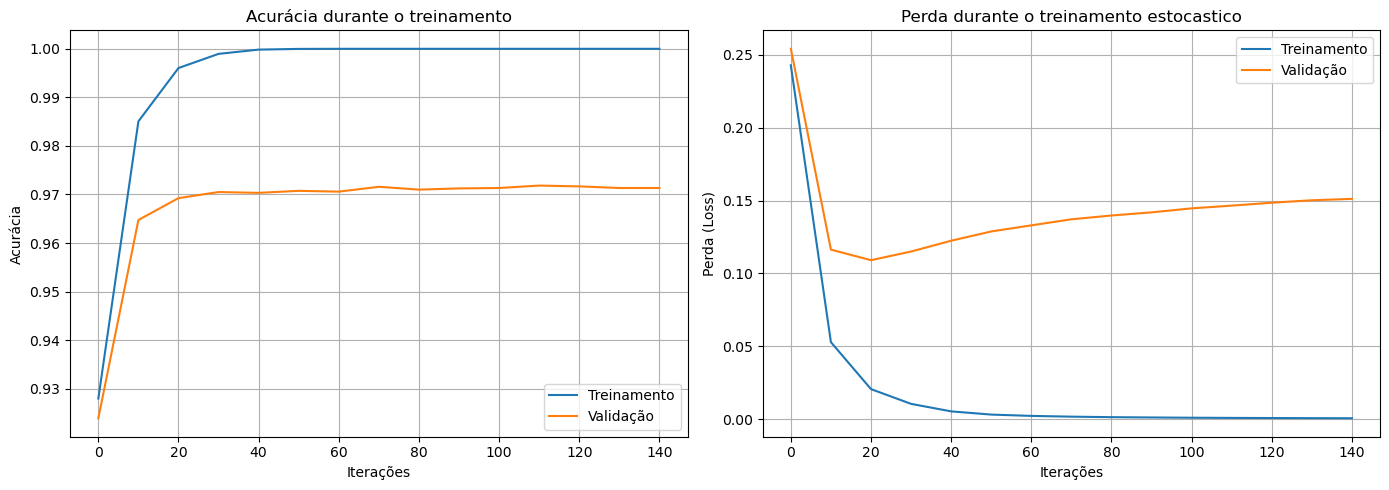

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(steps_stoch, train_accs_stoch, label='Treinamento')
plt.plot(steps_stoch, val_accs_stoch, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Acurácia")
plt.title("Acurácia durante o treinamento")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(steps_stoch, train_losses_stoch, label='Treinamento')
plt.plot(steps_stoch, val_losses_stoch, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Perda (Loss)")
plt.title("Perda durante o treinamento estocastico")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


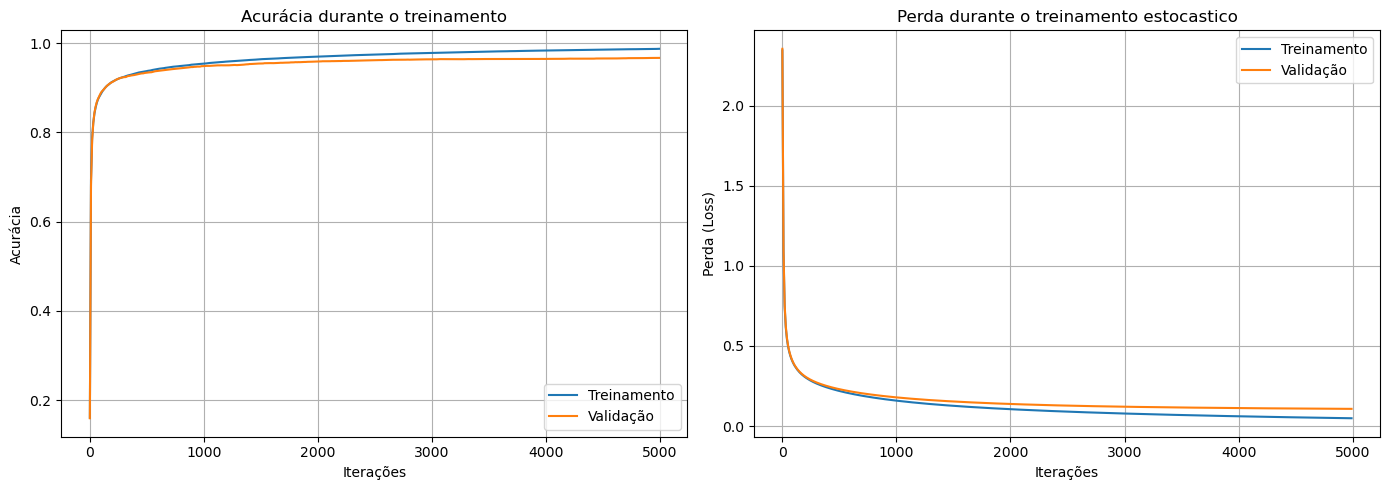

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(steps, train_accs, label='Treinamento')
plt.plot(steps, val_accs, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Acurácia")
plt.title("Acurácia durante o treinamento")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(steps, train_losses, label='Treinamento')
plt.plot(steps, val_losses, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Perda (Loss)")
plt.title("Perda durante o treinamento estocastico")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forw_prop(W1, b1, W2, b2, X)
    predictions = prediction(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = x_train[:, index, None]
    prediction = make_predictions(x_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)).get() * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [8]
Label:  8


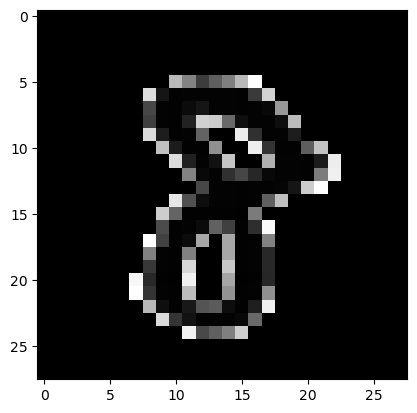

Prediction:  [9]
Label:  9


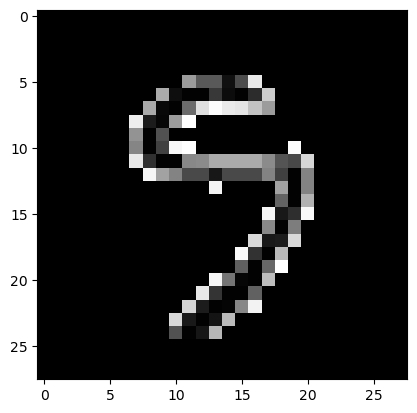

Prediction:  [7]
Label:  7


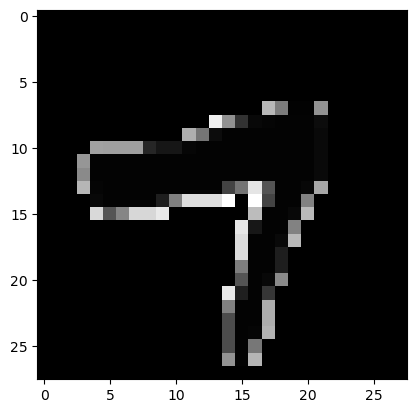

Prediction:  [4]
Label:  4


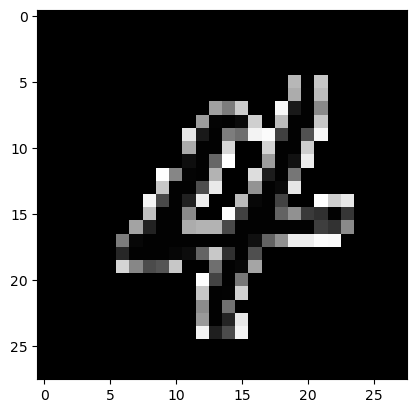

In [15]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)


teste gradient desc


In [43]:
dev_predictions = make_predictions(x_test, W1, b1, W2, b2)
acc(dev_predictions, y_test)

array(0.9682)

test stochastic grad desc

In [42]:
dev_predictions = make_predictions(x_test, W1_stoch, b1_stoch, W2_stoch, b2_stoch)
acc(dev_predictions, y_test)

array(0.9743)

teste momentum


teste adam
